In [1]:
import numpy as np

In [2]:
np.__version__

'1.13.3'

In [3]:
np.__file__

'/anaconda3/lib/python3.6/site-packages/numpy/__init__.py'

In [4]:
import pickle
from astropy.table import Table
import astropy.coordinates as coord
import astropy.units as u
from gala.coordinates import reflex_correct
from scipy.interpolate import interp1d
import pandas as pd

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import gala.coordinates as gc
from IPython.display import Image, display

In [6]:
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

In [7]:
import numpy as np
import scipy.stats


def getDust(G, bp, rp, ebv, maxnit=10):
    """ Compute the Gaia extinctions assuming relations from Babusieux
    Arguments: G, bp, rp, E(B-V)
    maxnit -- number of iterations
    Returns extinction in G,bp, rp
    Author: Sergey Koposov skoposov@cmu.edu
    """
    c1, c2, c3, c4, c5, c6, c7 = [0.9761, -0.1704,
                                  0.0086, 0.0011, -0.0438, 0.0013, 0.0099]
    d1, d2, d3, d4, d5, d6, d7 = [
        1.1517, -0.0871, -0.0333, 0.0173, -0.0230, 0.0006, 0.0043]
    e1, e2, e3, e4, e5, e6, e7 = [
        0.6104, -0.0170, -0.0026, -0.0017, -0.0078, 0.00005, 0.0006]
    A0 = 3.1*ebv
    P1 = np.poly1d([c1, c2, c3, c4][::-1])

    def F1(bprp): return np.poly1d(
        [c1, c2, c3, c4][::-1])(bprp)+c5*A0+c6*A0**2+c7*bprp*A0

    def F2(bprp): return np.poly1d(
        [d1, d2, d3, d4][::-1])(bprp)+d5*A0+d6*A0**2+d7*bprp*A0

    def F3(bprp): return np.poly1d(
        [e1, e2, e3, e4][::-1])(bprp)+e5*A0+e6*A0**2+e7*bprp*A0
    xind = np.isfinite(bp+rp+G)
    curbp = bp-rp
    for i in range(maxnit):
        AG = F1(curbp)*A0
        Abp = F2(curbp)*A0
        Arp = F3(curbp)*A0
        curbp1 = bp-rp-Abp+Arp

        delta = np.abs(curbp1-curbp)[xind]
        #print(scipy.stats.scoreatpercentile(delta[np.isfinite(delta)], 99))
        curbp = curbp1
    AG = F1(curbp)*A0
    Abp = F2(curbp)*A0
    Arp = F3(curbp)*A0
    return AG, Abp, Arp


In [8]:
def calc_distance(g, Ag):
    #Ag = 2.5*ebv
    gmag = g-Ag
    dist = 10.*10.**(0.2*(gmag-0.5))*1e-3
    return dist

In [9]:
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import matrix_product, matrix_transpose, rotation_matrix


class ArbitraryPoleFrame(coord.BaseCoordinateFrame):

    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'phi1'),
            coord.RepresentationMapping('lat', 'phi2'),
            coord.RepresentationMapping('distance', 'distance')],
        coord.SphericalCosLatDifferential:[
            coord.RepresentationMapping('d_lon_coslat', 'pm_phi1_cosphi2'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')],
        coord.SphericalDifferential: [
            coord.RepresentationMapping('d_lon', 'pm_phi1'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')]
    }

    pole = coord.CoordinateAttribute(frame=coord.ICRS)
    roll = coord.QuantityAttribute(default=0*u.degree)


@frame_transform_graph.transform(coord.DynamicMatrixTransform, coord.ICRS, ArbitraryPoleFrame)
def icrs_to_arbpole(icrs_coord, arbpole_frame):

    roll = arbpole_frame.roll
    pole = arbpole_frame.pole

    # Align z(new) with direction to M31
    mat1 = rotation_matrix(-pole.dec, 'y')
    mat2 = rotation_matrix(pole.ra, 'z')
    mat3 = rotation_matrix(roll, 'z')
    mat4 = rotation_matrix(90*u.degree, 'y')
    R = matrix_product(mat4, mat1, mat2, mat3)

    return R


@frame_transform_graph.transform(coord.DynamicMatrixTransform, ArbitraryPoleFrame, coord.ICRS)
def arbpole_to_icrs(arbpole_coord, icrs_frame):
    return matrix_transpose(icrs_to_arbpole(None, arbpole_coord))


In [10]:
savedir = '/Users/landerson/Dropbox\ \(Simons\ Foundation\)/RRLyraeGaiaSprint/'

In [11]:
with open('gaiaRRlyrae.pkl', 'rb') as f:
    d = Table(pickle.load(f))


In [12]:
len(d)

141387

In [13]:
d.keys()

['ra',
 'dec',
 'pmra',
 'pmdec',
 'parallax',
 'parallax_error',
 'int_average_g',
 'int_average_g_error',
 'g_absorption',
 'g_absorption_error',
 'pmra_error',
 'pmdec_error',
 'pmra_pmdec_corr',
 'ebv',
 'peak_to_peak_g',
 'num_clean_epochs_g',
 'astrometric_excess_noise',
 'phot_bp_mean_mag',
 'phot_rp_mean_mag',
 'g_transit_time',
 'g_transit_flux',
 'pf',
 'best_classification',
 'source_id']

In [14]:
Ag, Abp, Arp = getDust(d['int_average_g'], d['phot_bp_mean_mag'], d['phot_rp_mean_mag'], d['ebv'])

/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:680: RuntimeWarning: overflow encountered in multiply
  y = y * x + p[i]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in multiply
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in multiply
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in multiply
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in add
/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:680: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


In [15]:
bprp = (d['phot_bp_mean_mag'] - Abp) - (d['phot_rp_mean_mag'] - Arp)
distances = calc_distance(d['int_average_g'], Ag)
c = coord.SkyCoord(ra=d['ra']*u.deg, 
                   dec=d['dec']*u.deg, 
                  distance=distances*u.kpc)

cGal = c.transform_to(coord.Galactocentric)

In [16]:
cSag = c.transform_to(gc.Sagittarius)

/anaconda3/lib/python3.6/site-packages/astropy/coordinates/angles.py:646: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/anaconda3/lib/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/anaconda3/lib/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/anaconda3/lib/python3.6/site-packages/astropy/coordinates/angles.py:646: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):


In [17]:
cGalactic = c.transform_to(coord.Galactic)

/anaconda3/lib/python3.6/site-packages/astropy/coordinates/angles.py:646: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/anaconda3/lib/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/anaconda3/lib/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/anaconda3/lib/python3.6/site-packages/astropy/coordinates/angles.py:646: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):


In [18]:
good = ~np.isnan(d['pmra']) & \
       ~np.isnan(d['pmdec']) & \
       (d['ebv'] < 5) & (bprp < 1) & (Ag < 5) & \
       (d['best_classification'] == 'RRab') & \
       (np.abs(cGal.z) > 1*u.kpc) & \
       (np.abs(cSag.Beta) > 10.*u.deg) & \
       (np.sqrt((cGalactic.l - 280.4652*u.deg)**2. + (cGalactic.b - -32.8884*u.deg)**2) > 15*u.deg) & \
       (np.sqrt((cGalactic.l - 302.8084*u.deg)**2  + (cGalactic.b - -44.3277*u.deg)**2) > 10*u.deg)


/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/coordinates/angles.py:646: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/anaconda3/lib/python3.6/site-packages/astropy/coordinates/angles.py:646: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/anaconda3/lib/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/anaconda3/lib/python3.6/site-packages/a

In [19]:
data = d[good]

In [20]:
len(data)

42483

In [21]:
Ag, Abp, Arp = getDust(data['int_average_g'], data['phot_bp_mean_mag'], data['phot_rp_mean_mag'], data['ebv'])

In [22]:
bprp = (data['phot_bp_mean_mag'] - Abp) - (data['phot_rp_mean_mag'] - Arp)

In [23]:
distances = calc_distance(data['int_average_g'], Ag)
c = coord.SkyCoord(ra=data['ra']*u.deg, 
                   dec=data['dec']*u.deg, 
                   pm_ra_cosdec=data['pmra']*u.mas/u.yr,
                   pm_dec=data['pmdec']*u.mas/u.yr,
                   distance = distances*u.kpc, 
                   radial_velocity=0.*u.km/u.s)
cCorrect = reflex_correct(c)
cGal = cCorrect.transform_to(coord.Galactic)

In [24]:
cGalactic = cCorrect.transform_to(coord.Galactic)

In [25]:
cGalTable = Table()
cGalTable['l'] = cGalactic.l
cGalTable['b'] = cGalactic.b
cGalTable['pm_l_cosb'] = cGalactic.pm_l_cosb
cGalTable['pm_b'] = cGalactic.pm_b
cGalTable['distance'] = distances




In [26]:
cGalTable.write('rrlyraeDynamics.txt', format='ascii')

In [27]:
vl = (cGalactic.pm_l_cosb*cGalactic.distance).to(u.km/u.s, equivalencies=u.dimensionless_angles())
vb = (cGalactic.pm_b*cGalactic.distance).to(u.km/u.s, equivalencies=u.dimensionless_angles())


In [28]:
cGal.set_representation_cls('cartesian')

Text(0.5,1,'distances')

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


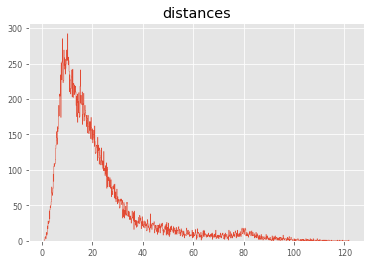

In [29]:
plt.hist(distances[~np.isnan(distances)], bins=1000, histtype='step')
plt.title('distances')

In [30]:
np.isnan(cGal.U).sum()
#for k in data.keys():
#    print(data[k][np.isnan(cGal.U)])
print(distances[np.isnan(cGal.U)], Ag[np.isnan(cGal.U)])

int_average_g
------------- ebv
---


In [31]:
locgalaxiesfile = '/Users/landerson/Dropbox (Simons Foundation)/data/Misc/NearbyGalaxies.dat'
locgaldata = Table.read(locgalaxiesfile, format='ascii')
gcfile = '/Users/landerson/Dropbox (Simons Foundation)/data/Misc/Harris-globclust.fits'
gcdata = Table.read(gcfile, format='fits')
locGalc = coord.SkyCoord(ra=locgaldata['RA'], dec=locgaldata['Dec'], unit=(u.hourangle, u.deg))
gcc     = coord.SkyCoord(ra=gcdata['ra'],     dec=gcdata['dec'], unit=(u.hourangle, u.deg))

locGalcGal = locGalc.transform_to(coord.Galactic)
gccGal = gcc.transform_to(coord.Galactic)

In [32]:
from sklearn.neighbors import KDTree as kdtree
import pandas as pd
import matplotlib as mpl

In [33]:
treedata = pd.DataFrame(data={'u':cGal.u/(1.*u.kpc), 
                              'v':cGal.v/(1.*u.kpc), 
                              'w':cGal.w/(1.*u.kpc),
                              'U':cGal.U/(10*u.km/u.s),
                              'V':cGal.V/(10*u.km/u.s), 
                              'W':cGal.W/(10*u.km/u.s)})

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


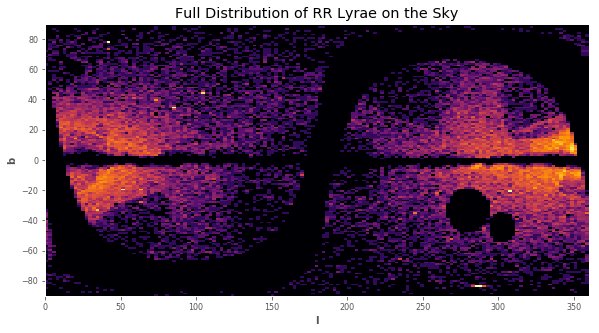

In [34]:
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'aspect': 'equal'})
nbins = 150
xbins = np.linspace(0, 360, nbins)
ybins = np.linspace(-90, 90, nbins)

H, xe, ye = np.histogram2d(cGalactic.l, cGalactic.b, bins=(xbins, ybins))
im = ax.pcolormesh(xe, ye, H.T + 1,
      cmap='inferno', norm=mpl.colors.LogNorm(vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
ax.set_title('Full Distribution of RR Lyrae on the Sky')
ax.set_xlabel('l')
ax.set_ylabel('b')
fig.savefig('rrlyraeDist.pdf', rasterized=True)

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


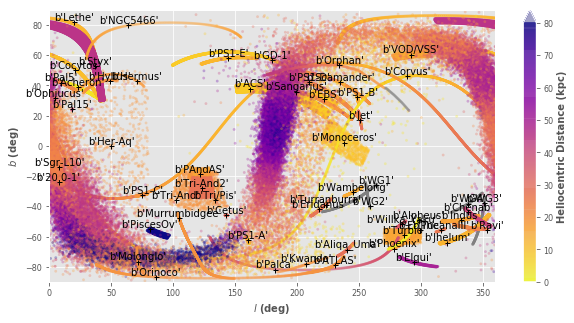

In [35]:
import galstreams
import matplotlib.pyplot as plt
%matplotlib inline
mwsts = galstreams.MWStreams(verbose=False)
fig=plt.figure(1,figsize=(10, 5))
ax=fig.add_subplot(111)
cmapp=plt.cm.plasma_r
cmapp.set_under('grey')   #If distance info is missing (-1), plot in grey
mwsts.plot_stream_compilation(ax,plot_colorbar=True,scat_kwargs=dict(vmin=0.,vmax=80.,cmap=cmapp, alpha=0.3),
                                  use_shortnames=False, cb_kwargs=dict(label='Heliocentric Distance (kpc)'), 
                                  verbose=False, cootype='gal')


ax.set_rasterized(True)
ax.set_xlim(0.,360.)
ax.set_ylim(-90.,90.)
ax.set_xlabel('$l$ (deg)')
ax.set_ylabel('$b$ (deg)')
fig.savefig('streams.pdf', rasterized=True, dpi=400)

In [36]:
tree = kdtree(treedata)

In [37]:
radius = 3.0


In [38]:
(ind, dist) = tree.query_radius(treedata, radius, count_only = False, return_distance = True)

In [39]:
maxMembers= 100
minMembers = 2
clumps = []
for i in ind:
    if (len(i)>=minMembers) & (len(i)<=maxMembers): 
        clumps.append(i)
print(len(clumps))

19036


In [40]:
cGalpm = cCorrect.transform_to(coord.Galactic)

In [41]:
try:
    clumpTable = pd.read_pickle('clumpTablePairs')
    displaySkyPlot=True
except FileNotFoundError:
    displaySkyPlot=False
    #clumpTable = Table()
    clumpTable = pd.DataFrame(columns = ('indices', 'ra', 'dec', 'pmra', 'pmdec', 'distance', 'width', 'angularSizeR', 'l', 'b'))
    #figAll, axAll = plt.subplots()
    figSky, axSky = plt.subplots(figsize=(10, 5))
    colors=iter(plt.cm.rainbow(np.linspace(0,1,len(clumps))))
    #axSky.pcolormesh(xe, ye, H.T, cmap='Greys', norm=mpl.colors.LogNorm(), alpha=0.75)
    mwsts.plot_stream_compilation(axSky,plot_colorbar=True,scat_kwargs=dict(vmin=0.,vmax=80.,cmap=cmapp, alpha=0.3),
                                  use_shortnames=False, cb_kwargs=dict(label='Heliocentric Distance (kpc)'), 
                                  verbose=False, cootype='gal')

    ti = 0
    distToKnown = 1.0 #deg
    widthOfClump = 1 # kpc
    maxSameAsBefore = 1
    for j in range(len(clumps)):
        #check that it's small in physical space
        small = treedata.iloc[clumps[j]]
        width = np.max((small.u - np.mean(small.u))**2 + (small.v - np.mean(small.v))**2 + (small.w - np.mean(small.w))**2) #kpc
        if width < widthOfClump :
            #check that it isn't something already known 
            co = cGalactic[clumps[j]]
            dist_known = np.zeros(len(co) + len(co))
            for ii, (ll, bb) in enumerate(zip(co.l, co.b)):
                dist_known[ii] = np.min(np.sqrt((ll - locGalcGal.l)**2 + (bb - locGalcGal.b)**2).value)
                dist_known[ii + len(co)] = np.min(np.sqrt((ll - gccGal.l)**2 + (bb - gccGal.b)**2).value)
            #print(np.min(dist_known))
            lmcdist = np.sqrt((ll.value - 280.4652)**2. + (bb.value - -32.8884)**2)
            smcdist = np.sqrt((ll.value - 302.8084)**2  + (bb.value - -44.3277)**2)
            if (np.min(dist_known) > distToKnown) & (lmcdist > 10) & (smcdist > 10): 
                #check that you haven't already plotted it 
                samesies = 0
                for k in range(j):
                    same = np.in1d(clumps[j], clumps[k])
                    #print(same, np.sum(same), j, k)
                    samesies += np.sum(same)
                if (samesies < maxSameAsBefore+1):
                    #color = next(colors)
                    dnow= data[clumps[j]]
                    clumpTable.loc[ti] = [clumps[j], dnow['ra'], dnow['dec'], dnow['pmra'], dnow['pmdec'], 
                                          distances[clumps[j]], width, np.max(width*u.kpc/cGalactic[clumps[j]].distance*180./np.pi), 
                                         np.median(cGalactic.l[clumps[j]]), np.median(cGalactic.b[clumps[j]])]
                    ti += 1
                    #print(samesies, clumps[j], dnow['ra'][0], dnow['dec'][0], width, np.max(width*u.kpc/cGalactic[clumps[j]].distance*180./np.pi))
                    axSky.scatter(cGalactic.l[clumps[j]], cGalactic.b[clumps[j]], s=len(clumps[j])*3)#, c=color)
                    #print(cGalactic.l[clumps[j]], cGalactic.b[clumps[j]])
    #axSky.scatter(locGalcGal.l, locGalcGal.b, s=40, facecolor='none', edgecolor='black', label='local galaxies')
    #axSky.scatter(gccGal.l, gccGal.b, s=40, facecolor='none', edgecolor='red', label='globular clusters')
    axSky.set_xlabel('l')
    axSky.set_ylabel('b')
    axSky.set_xlim(0, 360)
    axSky.set_ylim(-90, 90)
    axSky.legend(fontsize=15)
    axSky.set_rasterized(True)
    figSky.savefig('allsky_pairs.pdf', rasterized=True, dpi=400)
    #plt.close(fig)
    clumpTable.to_pickle('clumpTablePairs')

In [42]:
len(clumpTable)

2856

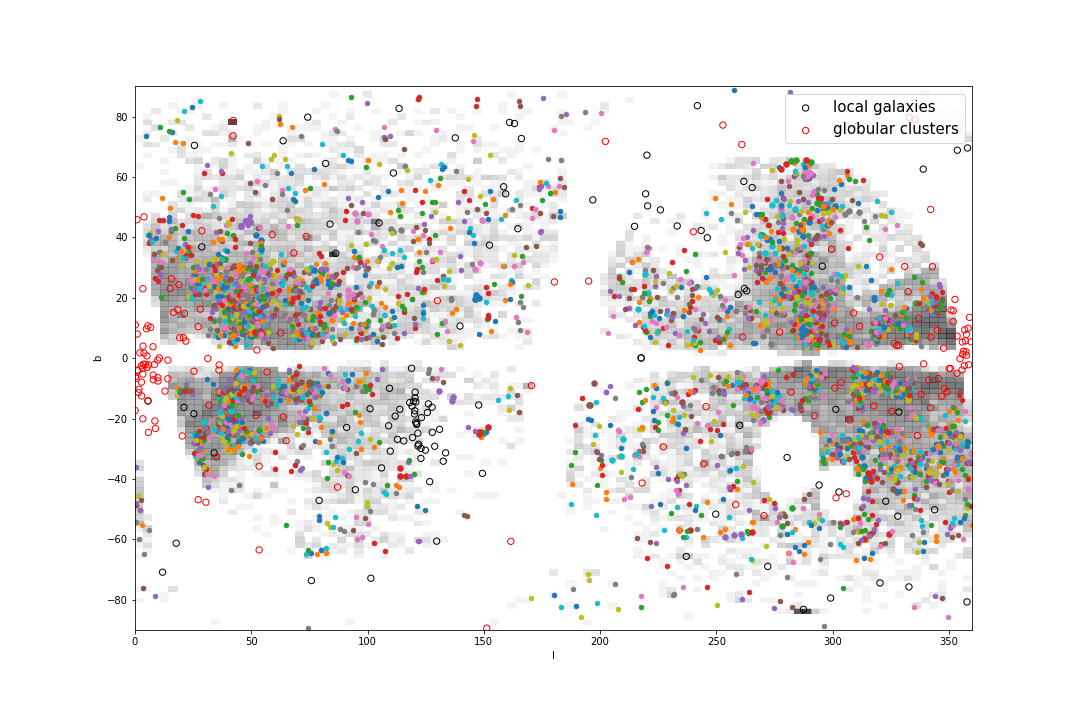

In [43]:
if displaySkyPlot:
    display(Image(filename='allsky_pairs.png'))

In [44]:
len(clumpTable)

2856

In [45]:
from os import path
import sqlutilpy as sqlutil
def queryDatabase(query, columns, post_query, cache_file='db.pickle', queryPro=None):

    #cache_file = "reducedPM2.pickle"

    if not path.exists(cache_file):
        if queryPro is not None:
            res = sqlutil.get(queryPro,
                          db='wsdb', host='cappc127.ast.cam.ac.uk', 
                          user='gaia_sprint', password='NOT@Gaia_sprint', 
                          asDict=True)
        else:
            res = sqlutil.get(query.format(','.join(columns), post_query),
                          db='wsdb', host='cappc127.ast.cam.ac.uk', 
                          user='gaia_sprint', password='NOT@Gaia_sprint', 
                          asDict=True)

        with open(cache_file, "wb") as f:
            pickle.dump(res, f)
        
    else:
        with open(cache_file, "rb") as f:
            res = pickle.load(f)
    return res

/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [46]:
from scipy.interpolate import interp1d
dataCMD_15 = Table.read('MIST_iso_5b18346c0ece6.iso.cmd', format='ascii.commented_header', header_start=12)
dataCMD_10 = Table.read('MIST_iso_5b19718e29c20.iso.cmd', format='ascii.commented_header', header_start=12)
dataCMD_05 = Table.read('MIST_iso_5b19717ee7821.iso.cmd', format='ascii.commented_header', header_start=12)
dataCMD_20 = Table.read('MIST_iso_5b1aa1d56d073.iso.cmd', format='ascii.commented_header', header_start=12)

-1.9285079449866906
-2.498738805154451
-2.864049043887721


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


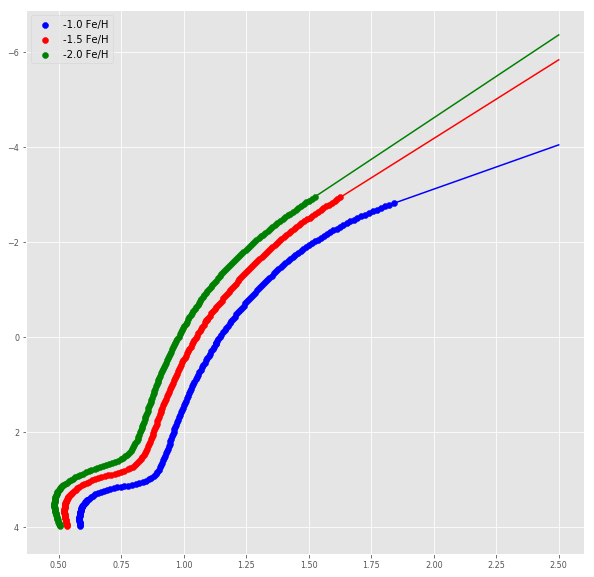

In [47]:
plt.figure(figsize=(10,10))
colors = ['blue', 'red', 'green', 'black']
for dataCMD, l, c in zip([dataCMD_10, dataCMD_15, dataCMD_20], ['-1.0', '-1.5', '-2.0'], colors):
    good = (dataCMD['phase'] < 3) & (dataCMD['phase'] > -1) & (dataCMD['Gaia_G_DR2Rev'] < 4)
    plt.scatter(dataCMD['Gaia_BP_DR2Rev'][good] - dataCMD['Gaia_RP_DR2Rev'][good], dataCMD['Gaia_G_DR2Rev'][good], 
                label='{0} Fe/H'.format(l), c=c)

    f = interp1d(dataCMD['Gaia_BP_DR2Rev'][good] - dataCMD['Gaia_RP_DR2Rev'][good], dataCMD['Gaia_G_DR2Rev'][good], fill_value='extrapolate')
    xx = np.linspace(1, 2.5)
    plt.plot(xx, f(xx), color=c)
    #plt.plot(xx, f(xx)+2, alpha=0.5, color=c)
    #plt.plot(xx, f(xx)-2, alpha=0.5, color=c)
    print(f(1.5))
plt.legend()
plt.gca().invert_yaxis()

In [48]:
#clumpSky = coord.SkyCoord(ra=clumpTable.ra[0]*u.deg, dec=clumpTable.dec[0]*u.deg, distance=clumpTable.distance*u.kpc)

In [49]:
#clumpGal= clumpSky.transform_to(coord.Galactocentric)

In [50]:
#r = np.sqrt(clumpGal.x.value**2 + clumpGal.y.value**2 + clumpGal.z.value**2)

In [51]:
#plt.hist(r, bins=np.logspace(-1, 1.8, 50), histtype='step', log=True)
#plt.title('galactocentric radius')
#plt.xscale('log')
#plt.xlim(2, )
#plt.ylim(1,)

In [52]:
len(clumpTable)

2856

In [53]:
plotAllPairs = False

In [54]:
if plotAllPairs:
    mpl.rc('font',**{'family':'sans-serif', 'serif':['Computer Modern Serif'], 
                 'sans-serif':['Helvetica'], 'size':16, 
                 'weight':500, 'variant':'normal'}) 
    dataCMD = dataCMD_15
    good = (dataCMD['phase'] <3) & (dataCMD['phase'] > -1) & (dataCMD['Gaia_G_DR2Rev'] < 4)
    f = interp1d(dataCMD['Gaia_BP_DR2Rev'][good] - dataCMD['Gaia_RP_DR2Rev'][good], dataCMD['Gaia_G_DR2Rev'][good], fill_value='extrapolate')
    xx = np.linspace(1, 2.5)

    minStarsRGB = 1
    maxMagDiff = 2
    minRedColor = 1.25
    minAngularDistance = 1.0 #deg
    minSigPM = 0.5 #mas/yr
    index_order = np.argsort(clumpTable['angularSizeR'].values)
    #print(index_order[1])
    minr = np.min(clumpTable['angularSizeR'])
    print('distance, pmra, pmdec, pmraWidth, pmdecWidth, ra, dec, angular distance')
    for ii, i in enumerate(range(len(index_order))):
        i = index_order[i]
        nstars = len(clumpTable.loc[i]['ra'])
        ra = clumpTable.loc[i]['ra'][0]
        dec = clumpTable.loc[i]['dec'][0]
        pmra = clumpTable.loc[i]['pmra'][0]
        pmdec = clumpTable.loc[i]['pmdec'][0]
        angular_distance = np.max((clumpTable.loc[i]['angularSizeR'], minAngularDistance))
        distance = clumpTable.loc[i]['distance'][0]
        #print(ra, dec, pmra, pmdec, angular_distance, distance)

        medra = np.median(clumpTable.loc[i]['ra'])
        meddec = np.median(clumpTable.loc[i]['dec'])
        pm2Max = pmra**2 + pmdec**2
        pmramed = np.median(clumpTable.loc[i]['pmra'])
        pmdecmed = np.median(clumpTable.loc[i]['pmdec'])
        pmrasig = np.max((np.sqrt(np.var(clumpTable.iloc[i]['pmra']))*4, minSigPM))
        pmdecsig = np.max((np.sqrt(np.var(clumpTable.iloc[i]['pmdec']))*4, minSigPM))
        maxParallax = 10./distance
        print(distance, pmramed, pmdecmed, pmrasig, pmdecsig, angular_distance)


        queryPro = """WITH x AS (SELECT  * FROM gaia_dr2.gaia_source AS gs WHERE q3c_radial_query(gs.ra, gs.dec, {0}, {1}, {2}))
        SELECT x.ra, x.dec, x.pmra, x.pmdec, phot_g_mean_mag, ebv, phot_bp_mean_mag, phot_rp_mean_mag
            FROM x
                WHERE parallax < {3} AND abs(pmra - {4:0.6f}) < {5:0.6f} AND abs(pmdec - {6:0.6f}) < {7:0.6f};""".format(medra, meddec, 
                                                                                                                             angular_distance, 
                                                                                                                             maxParallax, 
                                                                                                                             pmramed, pmrasig,
                                                                                                                             pmdecmed, pmdecsig)


        #columns = ['parallax', 'int_average_g', 'ebv', 'phot_bp_mean_mag', 'phot_rp_mean_mag']
        #query = """select {0} from gaia_dr2.gaia_source as gs, gaia_DR2.vari_rrlyrae as rr {1}"""
        #cuts = "WHERE ".format(ra, dec, angular_distance)
        query = ""
        columns = ""
        cuts = ""
        res = queryDatabase(query, columns, cuts, cache_file='rrlyrae_pairs_{0}.pkl'.format(ii), queryPro=queryPro)


        dnow = Table(res)
        Ag, Abp, Arp = getDust(dnow['phot_g_mean_mag'], dnow['phot_bp_mean_mag'], dnow['phot_rp_mean_mag'], dnow['ebv'])
        bprp = (dnow['phot_bp_mean_mag'] - Abp) - (dnow['phot_rp_mean_mag'] - Arp)
        MG = dnow['phot_g_mean_mag'] - Ag - 5.*np.log10(distance*1e3/10)

        red = bprp > minRedColor
        notTurnOff =  MG < 4.*bprp + 12

        if np.logical_or((np.sum((MG[red & notTurnOff] - f(bprp[red & notTurnOff])) <= maxMagDiff) >= minStarsRGB), len(dnow) < 100) :

            fig, ax = plt.subplots(1, 3, figsize=(15, 5))

            if len(dnow) > 4000:
                HH, xx, yy = np.histogram2d(dnow['ra'], dnow['dec'], bins=100)
                im = ax[0].pcolormesh(xx, yy, HH.T,
                  cmap='inferno', norm=mpl.colors.LogNorm())
            else:
                if len(dnow) < 100:
                    size = 20
                else:
                    size = 3
                ax[0].scatter(dnow['ra'], dnow['dec'], s=10, label=('{0:0.4f},{1:0.4f}'.format(medra, meddec)))
            ax[0].legend()
            ax[0].set_xlabel('ra')
            ax[0].set_ylabel('dec')

            if len(dnow) > 10000:
                xbins = np.linspace(0, 2.5, 50)
                ybins = np.linspace(10, 20, 200)
                HH, xx, yy = np.histogram2d(bprp, dnow['phot_g_mean_mag'] - Ag, bins=(xbins, ybins))
                im = ax[1].pcolormesh(xx, yy, HH.T,
                  cmap='inferno', norm=mpl.colors.LogNorm())
                ax[1].invert_yaxis()
                ax[1].set_ylim(20, 10)
            else:
                if len(dnow) < 100:
                    size = 20
                else:
                    size = 3
                ax[1].scatter(bprp, dnow['phot_g_mean_mag'] - Ag, s=size)
                ax[1].set_xlim(-1.0, 2.5)
                ax[1].set_ylim(20, 10)
            for dataCMD, l, c in zip([dataCMD_10, dataCMD_15, dataCMD_20], ['-1.0', '-1.5', '-2.0'], colors):
                good = (dataCMD['phase'] < 4) & (dataCMD['phase'] > -1)
                ax[1].scatter(dataCMD['Gaia_BP_DR2Rev'][good] - dataCMD['Gaia_RP_DR2Rev'][good], 
                              dataCMD['Gaia_G_DR2Rev'][good] + 5.*np.log10(distance*1e3/10), s=1, alpha=0.5, label='{0} Fe/H'.format(l), c='black')

            #ax[1].scatter(cmd_bprp, cmd_MG + 5.*np.log10(distance*1e3/10), s=3, alpha=0.1)
            ax[0].set_title('{0:0.2f} kpc'.format(distance))
            ax[1].set_xlabel('bp - rp')
            ax[1].set_ylabel('G')
            ax[1].set_title('{0} RRlyrae {1}'.format(nstars, i))

            ax[2].pcolormesh(xe, ye, H.T, cmap='Greys', norm=mpl.colors.LogNorm(), alpha=0.75)
            ax[2].scatter(clumpTable.loc[i]['l'], clumpTable.loc[i]['b'], s=100)
            ax[2].scatter(locGalcGal.l, locGalcGal.b, s=40, facecolor='none', edgecolor='black', label='local galaxies', alpha=0.5, zorder=np.inf)
            ax[2].scatter(gccGal.l, gccGal.b, s=40, facecolor='none', edgecolor='red', label='globular clusters', alpha=0.5, zorder=np.inf)
            ax[2].set_xlabel('l')
            ax[2].set_ylabel('b')
            ax[2].set_xlim(0, 360)
            ax[2].set_ylim(-90, 90)
            vtannow = np.sqrt(pmra**2 + pmdec**2)*4.*distance
            ax[2].set_title('{0:0.2f} km/s'.format(vtannow))
            plt.tight_layout()
            fig.savefig('cmd_rrlyrae_pairs_{0:04d}.png'.format(ii))
            plt.close(fig)

            #plt.gca().invert_yaxis()

In [55]:
if plotAllPairs:

    #figAll, axAll = plt.subplots()
    figSky, axSky = plt.subplots(figsize=(15, 10))
    colors=iter(plt.cm.rainbow(np.linspace(0,1,len(clumps))))
    mpl.rc('font',**{'family':'sans-serif', 'serif':['Computer Modern Serif'], 
                 'sans-serif':['Helvetica'], 'size':16, 
                 'weight':500, 'variant':'normal'}) 
    for j, ci in enumerate(clumps):
        samesies = 0
        for k in range(j):
            same = np.in1d(clumps[j], clumps[k])
            samesies += np.sum(same)
        #if clumps[j] != clumps[j-1]
        if samesies < 1:
            small = treedata.iloc[clumps[j]]
            co = cGalactic[clumps[j]]
            vll = vl[clumps[j]]
            vbb = vb[clumps[j]]
            dist_known_gal = np.zeros(len(co))
            dist_known_gcc = np.zeros(len(co))
            for ii, (ll, bb) in enumerate(zip(co.l, co.b)):
                dist_known_gal[ii] = np.min(np.sqrt((ll - locGalcGal.l)**2 + (bb - locGalcGal.b)**2).value)
                dist_known_gcc[ii] = np.min(np.sqrt((ll - gccGal.l)**2 + (bb - gccGal.b)**2).value)
            dist_known = np.concatenate((dist_known_gal, dist_known_gcc))
            if np.min(dist_known) < 5: 
                continue
            fig, ax = plt.subplots(ncols=4, figsize=(20, 5))
            xx = [co.l, co.b, co.l]
            yy = [co.b, co.distance, co.distance]
            vxx = [vll, vbb, vll]
            vyy = [vbb, np.zeros(len(vbb)), np.zeros(len(vll))]
            #xx = [small.u, small.v, small.w]
            #yy = [small.v, small.w, small.u]
            #vxx = [small.U, small.V, small.W]
            #vyy = [small.V, small.W, small.U]
            lxx = ['l', 'b', 'l']
            lyy = ['b', 'd', 'd']
            color = next(colors)
            for i, (x, y, vx, vy, lx, ly) in enumerate(zip(xx, yy, vxx, vyy, lxx, lyy)):
                ax[i].quiver(x, y, vx, vy, color=color)
                ax[i].set_xlabel(lx)
                ax[i].set_ylabel(ly)
                #axAll.quiver(x, y, vx, vy)
            ax[3].pcolormesh(xe, ye, H.T, cmap='Greys', norm=mpl.colors.LogNorm(), alpha=0.75)
            ax[3].scatter(co.l, co.b, s=40, c=color)
            ax[3].scatter(locGalcGal.l, locGalcGal.b, s=40, facecolor='none', edgecolor='black', label='local galaxies')
            ax[3].scatter(gccGal.l, gccGal.b, s=40, facecolor='none', edgecolor='red', label='globular clusters')
            ax[3].set_xlabel('l')
            ax[3].set_ylabel('b')
            ax[3].set_xlim(0, 360)
            ax[3].set_ylim(-90, 90)
            #ax[3].legend(fontsize=15)
            plt.tight_layout()
            fig.savefig('rrLyrae_kdtree_{0:03d}.png'.format(j))
            plt.close(fig)
            axSky.scatter(cGalactic.l[clumps[j]], cGalactic.b[clumps[j]], s=len(clumps[j])*10, c=color)
            print(clumps[j])
    axSky.scatter(locGalcGal.l, locGalcGal.b, s=40, facecolor='none', edgecolor='black')
    axSky.scatter(gccGal.l, gccGal.b, s=40, facecolor='none', edgecolor='red')
    axSky.set_xlabel('l')
    axSky.set_ylabel('b')
    axSky.set_xlim(0, 360)
    axSky.set_ylim(-90, 90)
    #plt.close(fig)

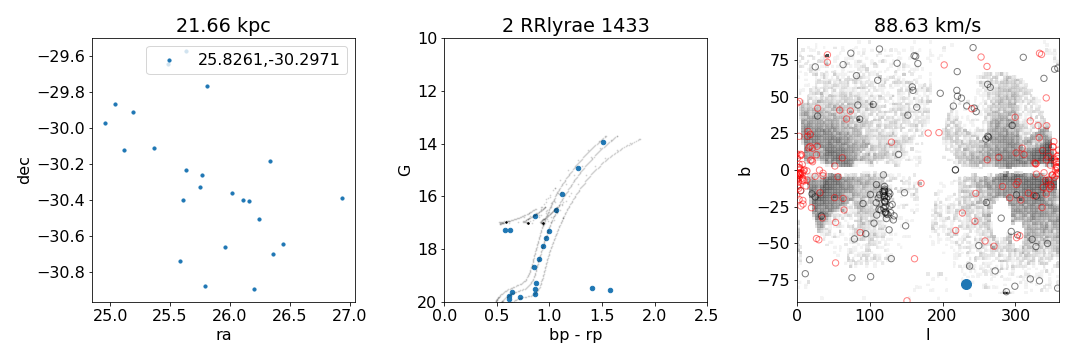

In [56]:
currentClump = clumpTable.loc[1433]
currentDist = np.median(currentClump['distance'])
maxParallax = 10./currentDist
display(Image(filename='cmd_rrlyrae_pairs_0066.png'))

In [57]:
! rm best_candidate_cmd_2deg.pkl

rm: best_candidate_cmd_2deg.pkl: No such file or directory


In [58]:
# Look around the best CMD...
dataCMD = dataCMD_15
good = (dataCMD['phase'] <3) & (dataCMD['phase'] > -1) & (dataCMD['Gaia_G_DR2Rev'] < 4)
f = interp1d(dataCMD['Gaia_BP_DR2Rev'][good] - dataCMD['Gaia_RP_DR2Rev'][good], dataCMD['Gaia_G_DR2Rev'][good], fill_value='extrapolate')
xx = np.linspace(1, 2.5)
queryPro = """WITH x AS (SELECT  * FROM gaia_dr2.gaia_source AS gs WHERE q3c_radial_query(gs.ra, gs.dec, {0}, {1}, {2}))
    SELECT x.ra, x.dec, x.pmra, x.pmdec, phot_g_mean_mag, ebv, phot_bp_mean_mag, phot_rp_mean_mag
        FROM x
            WHERE parallax < {3} AND abs(pmra - {4:0.6f}) < {5:0.6f} AND abs(pmdec - {6:0.6f}) < {7:0.6f};""".format(30, -35., #26.0, -30., 
                                                                                                                         20, 
                                                                                                                         maxParallax, 
                                                                                                                         0., 0.25,
                                                                                                                         -1, 0.25)

query = ""
columns = ""
cuts = ""
res = queryDatabase(query, columns, cuts, cache_file='best_candidate_cmd_2deg.pkl', queryPro=queryPro)

In [59]:
bestCMD = Table(res)
bestCMD

ra,dec,pmra,pmdec,phot_g_mean_mag,ebv,phot_bp_mean_mag,phot_rp_mean_mag
float64,float64,float64,float64,float32,float32,float32,float32
6.67196554421,-42.8167928005,0.105136526154,-0.961479643261,20.0754,0.005774,20.1437,19.6911
6.8191543875,-42.7411286549,0.203583503877,-0.784636065686,19.7797,0.005412,19.9965,19.2991
6.63756712204,-41.8601465938,0.214431378308,-1.00092682121,20.1033,0.005766,19.6181,19.3114
6.36171814936,-41.4589444688,-0.187294150628,-1.1031072586,19.6225,0.008966,19.6515,19.3096
6.45145806285,-41.1291869641,0.216752933522,-0.805286569541,20.61,0.01182,20.6392,19.9579
7.79860730872,-44.6180009549,0.178727904561,-1.12927303818,18.5624,0.009127,18.9782,17.9695
7.80881905598,-44.3150581436,-0.211291930903,-1.1164943825,19.6739,0.00686,20.0314,19.0261
8.28953879208,-44.4993461498,-0.14294324407,-0.926543921271,19.6014,0.006807,19.76,19.0905
7.72299123767,-44.0755890674,0.00227216625642,-0.845809556762,19.9367,0.008192,20.2442,19.307


/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


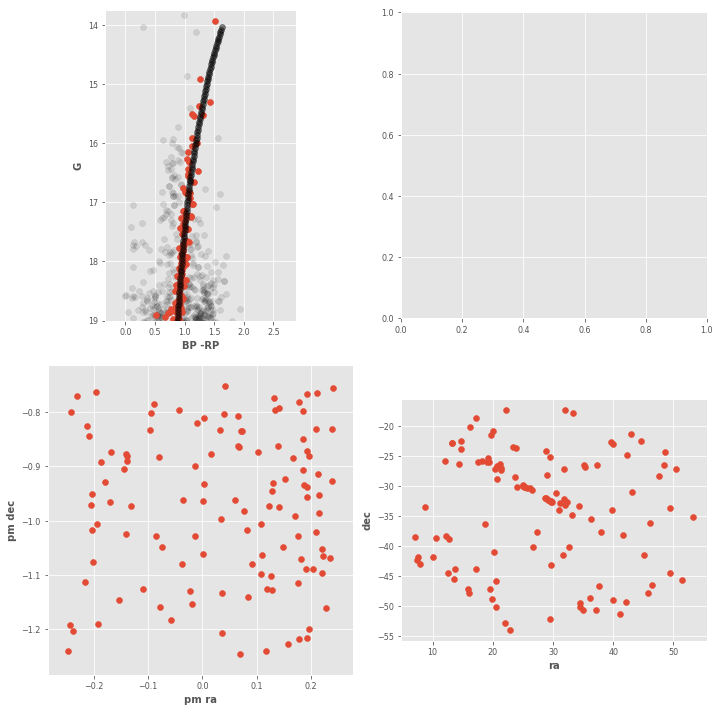

In [60]:
dataCMD = dataCMD_15
good = (dataCMD['phase'] <3) & (dataCMD['phase'] > -1) & (dataCMD['Gaia_G_DR2Rev'] < 4)
model = dataCMD[good]

Ag, Abp, Arp = getDust(bestCMD['phot_g_mean_mag'], bestCMD['phot_bp_mean_mag'], bestCMD['phot_rp_mean_mag'], bestCMD['ebv'])

fig, axes = plt.subplots(2, 2 ,subplot_kw={'aspect': 'equal'}, figsize=(10, 10))
axes = axes.flatten()
#medDist = np.median(clumpTable.loc[1433]['distance'])


modelG = model['Gaia_G_DR2Rev'] + 5.*np.log10(currentDist*1e3/10)
modelbprp = model['Gaia_BP_DR2Rev'] - model['Gaia_RP_DR2Rev']
f = interp1d(modelbprp, modelG, fill_value='extrapolate')

databprp = bestCMD['phot_bp_mean_mag']-Abp - bestCMD['phot_rp_mean_mag']+Arp
dataG = bestCMD['phot_g_mean_mag']-Ag
xx = np.linspace(databprp.min(), databprp.max(), len(databprp))
antitight = (np.abs(dataG-f(databprp)) > 1.0) & (dataG < 22) & (databprp > -1)
tight = (np.abs(dataG-f(databprp)) < 1.0) & (dataG < 19) & (databprp > -1)

pmra = bestCMD['pmra'][tight]
pmdec = bestCMD['pmdec'][tight]
delta = 0.5
x=np.linspace(0,70)
axes[2].scatter(pmra, pmdec)
axes[2].set_xlabel('pm ra')
axes[2].set_ylabel('pm dec')

#axes[1].quiver(bestCMD['ra'][tight], bestCMD['dec'][tight], pmra, pmdec)
axes[3].scatter(bestCMD['ra'][tight], bestCMD['dec'][tight])
#for ax in [axes[1]]:
#    ax.set_xlim(0, 70)
axes[3].set_xlabel('ra')
axes[3].set_ylabel('dec')
axes[0].scatter(databprp, dataG, alpha=0.1, color='black')
axes[0].scatter(databprp[tight], 
                dataG[tight])
axes[0].scatter(modelbprp, 
                modelG, alpha=0.5, label='{0} Fe/H'.format(l), c='black')
axes[0].plot(xx, f(xx))
axes[0].invert_yaxis()
#fig.savefig('stream1_pos_pm_cmd.pdf')
axes[0].set_xlabel('BP -RP')
axes[0].set_ylabel('G')
axes[0].set_ylim(19, 13.75)
plt.tight_layout()
fig.savefig('stream_from_cmd.pdf', rasterized=True)

#line = (-2/3+0.01) * (ra) -40/3
stream = (np.abs(((-2/3+0.01)*(bestCMD['ra'])-40/3) - bestCMD['dec']) < delta) #& (bestCMD['ra'] < 50)
fig, axes = plt.subplots(1, 2, figsize=(10,10), subplot_kw={'aspect': 'equal'})
axes[0].scatter(bestCMD['ra'][tight], bestCMD['dec'][tight], s=1)
#axes[1].plot(x,(-2/3+0.01) * (x) -40/3 )
axes[0].plot(x,(-2/3+0.01) * (x) -40/3 -delta, c='black', alpha=0.5)
axes[0].plot(x,(-2/3+0.01) * (x) -40/3 +delta, c='black', alpha=0.5)
axes[0].set_xlabel('ra')
axes[0].set_ylabel('dec')
axes[0].grid()

axes[1].scatter(databprp, dataG, alpha=0.05, color='black', edgecolor="none")
axes[1].scatter(databprp[stream], dataG[stream], s=100)
axes[1].scatter(modelbprp, modelG, s=1, alpha=0.5, label='{0} Fe/H'.format(l), c='red')
axes[1].plot(xx, f(xx))
axes[1].invert_yaxis()
#fig.savefig('stream1_on_v_off_line.pdf')
axes[1].set_xlabel('BP - RP')
axes[1].set_ylabel('G')
axes[1].set_ylim(21, 13.75)
fig.savefig('stream_on_sky.pdf', rasterized=True)

In [61]:
bestCMD.keys()

['ra',
 'dec',
 'pmra',
 'pmdec',
 'phot_g_mean_mag',
 'ebv',
 'phot_bp_mean_mag',
 'phot_rp_mean_mag']

(-1.0, 2.5)

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


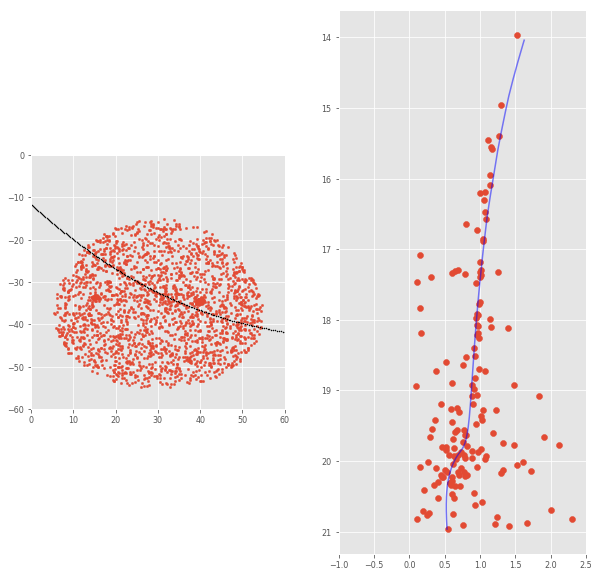

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(10,10), subplot_kw={'aspect': 'equal'})
#pole of atlas
#(α, δ) = 77.◦16, 46.◦92
rapole = 77.16
decpole = 46.92
#draw great circle 
phi1 = np.linspace(0, 360.00001, 1024)
phi2 = np.zeros(len(phi1))
pole = coord.ICRS(ra=rapole*u.deg, dec=decpole*u.deg)
testobserved = ArbitraryPoleFrame(phi1=phi1*u.deg, phi2=phi2*u.deg, pole=pole)
gal = testobserved.transform_to(coord.Galactic)
eq = testobserved.transform_to(coord.ICRS)
ax[0].scatter(bestCMD['ra'], bestCMD['dec'], s=5)
ax[0].scatter(eq.ra, eq.dec, c='black', s=1)
ax[0].set_xlim(0, 60)
ax[0].set_ylim(-60, 0)

f = interp1d(eq.ra, eq.dec)
tight = np.abs(bestCMD['dec'] - f(bestCMD['ra'])) < 1
ax[1].scatter(bestCMD['phot_bp_mean_mag'][tight] - bestCMD['phot_rp_mean_mag'][tight], bestCMD['phot_g_mean_mag'][tight])
ax[1].invert_yaxis()
ax[1].plot(modelbprp, modelG, alpha=0.5, label='{0} Fe/H'.format(l), c='blue')
ax[1].set_xlim(-1.0, 2.5)

In [63]:
from scipy.interpolate import interp1d
f = interp1d(eq.ra, eq.dec)

In [64]:
try: 
    clumpTableAll = pd.read_pickle('clumpTableAll')
except FileNotFoundError:
    clumpTableAll = pd.DataFrame(columns = ('indices', 'medra', 'meddec', 'ra', 'dec', 
                                            'pmra', 'pmdec', 'distance', 'width', 'angularSizeR', 'l', 'b', 'pml', 'pmb'))
    for j in range(len(clumps)):
        dnow= data[clumps[j]]
        small = treedata.iloc[clumps[j]]
        width = np.max((small.u - np.mean(small.u))**2 + (small.v - np.mean(small.v))**2 + (small.w - np.mean(small.w))**2) #kpc

        clumpTableAll.loc[j] = [clumps[j], np.median(dnow['ra']), np.median(dnow['dec']), dnow['ra'], dnow['dec'], dnow['pmra'], dnow['pmdec'], 
                              distances[clumps[j]], width, np.max(width*u.kpc/cGalactic[clumps[j]].distance*180./np.pi), 
                              cGalactic.l[clumps[j]].to(u.deg).value, cGalactic.b[clumps[j]].to(u.deg).value, 
                              cGalpm.pm_l_cosb[clumps[j]].value, cGalpm.pm_b[clumps[j]].value]
        #ti += 1
    clumpTableAll.to_pickle('clumpTableAll')

In [65]:
try: 
    clumpTableUniform = pd.read_pickle('clumpTableUniform')
except FileNotFoundError:
    clumpTableUniform = pd.DataFrame(columns = ('pairNumber', 'ra', 'dec',
                                                'pmra', 'pmdec', 'distance', 'width', 
                                                'angularSizeR', 'l', 'b', 'pml', 'pmb'))
    k = 0
    for j in range(len(clumps)):
        dnow = data[clumps[j]]
        small = treedata.iloc[clumps[j]]
        width = np.max((small.u - np.mean(small.u))**2 + (small.v - np.mean(small.v))**2 + (small.w - np.mean(small.w))**2) #kpc
        for i, c in enumerate(clumps[j]):
            clumpTableUniform.loc[k] = [j, dnow['ra'][i], dnow['dec'][i], dnow['pmra'][i], dnow['pmdec'][i], 
                              distances[c], width, np.max(width*u.kpc/cGalactic[c].distance*180./np.pi), 
                              cGalactic.l[c].to(u.deg).value, cGalactic.b[c].to(u.deg).value, 
                              cGalpm.pm_l_cosb[c].value, cGalpm.pm_b[c].value]
            k += 1
        #ti += 1
    clumpTableUniform.to_pickle('clumpTableUniform')

In [66]:
atlasDec

NameError: name 'atlasDec' is not defined

In [ ]:
rapole = 77.16
decpole = 46.92
#draw great circle 
phi1 = np.linspace(0, 360.00001, 2048)
phi2 = np.zeros(len(phi1))
pole = coord.ICRS(ra=rapole*u.deg, dec=decpole*u.deg)
testobserved = ArbitraryPoleFrame(phi1=phi1*u.deg, phi2=phi2*u.deg, pole=pole)
gal = testobserved.transform_to(coord.Galactic)
eq = testobserved.transform_to(coord.ICRS)
f = interp1d(eq.ra, eq.dec, fill_value='extrapolate')
eq.ra.min(), eq.ra.max()

In [ ]:
clumpTableUniform.ra.max()

In [ ]:
altasDec = f(clumpTableUniform['ra'])
locs = (np.abs(clumpTableUniform['dec'] - altasDec) < 5) & (clumpTableUniform['distance'] > 20) & (clumpTableUniform['distance'] < 24)  & (clumpTableUniform['ra'] < 150)#& (medb < -25)#degrees

In [ ]:
clumpTableUniform[locs]

In [ ]:
%gui qt

In [ ]:
from glue import qglue

clumpTableAll[['ra', 'dec', 'pmra', 'pmdec', 'distance']][locs]

In [ ]:
app = qglue(data1 = clumpTableUniform[locs])

In [ ]:
figEq, axEq = plt.subplots(2, 2, figsize=(10,10))
figGal, axGal = plt.subplots(2, 2, figsize=(10,10))
axEq = axEq.flatten()
axGal = axGal.flatten()
#pole of atlas
#(α, δ) = 77.◦16, 46.◦92
rapole = 77.16
decpole = 46.92
#draw great circle 
phi1 = np.linspace(0, 360.00001, 2048)
phi2 = np.zeros(len(phi1))
pole = coord.ICRS(ra=rapole*u.deg, dec=decpole*u.deg)
testobserved = ArbitraryPoleFrame(phi1=phi1*u.deg, phi2=phi2*u.deg, pole=pole)
gal = testobserved.transform_to(coord.Galactic)
eq = testobserved.transform_to(coord.ICRS)

medDist = clumpTableAll['distance'].map(lambda x: np.median(x))
medl = clumpTableAll['l'].map(lambda x: np.median(x))
medb = clumpTableAll['b'].map(lambda x: np.median(x))
f = interp1d(eq.ra, eq.dec)
altasDec = f(clumpTableAll['medra'])
locs = (np.abs(clumpTableAll['meddec'] - altasDec) < 5) & (medDist> 20) & (medDist < 24)  & (clumpTableAll.medra < 150)#& (medb < -25)#degrees

figSkyS, axSkyS = plt.subplots(2, figsize=(10,10))
axSkyS[0].scatter(eq.ra.value, eq.dec.value)
axSkyS[1].scatter(gal.l.value, gal.b.value)

for ras, decs, dists, ls, bs, pmls, pmbs, pmras, pmdecs in zip(clumpTableAll[locs].ra, clumpTableAll[locs].dec, 
                            clumpTableAll[locs].distance, clumpTableAll[locs].l, clumpTableAll[locs].b,
                                                              clumpTableAll[locs].pml, clumpTableAll[locs].pmb,
                                                              clumpTableAll[locs].pmra, clumpTableAll[locs].pmdec):
    #import pdb;pdb.set_trace()
    
    axEq[0].scatter(ras, decs)
    for r, d, pr, pde, di in zip(ras, decs, pmras, pmdecs, dists):
        axEq[1].quiver(r, d, pr, pde)
        axEq[3].quiver(r, di, pr, pde)
        #import pdb; pdb.set_trace()
    axEq[2].scatter(ras, dists)
    

    axGal[0].scatter(ls, bs)
    for ll, bb, pll, pbb, di in zip(ls, bs, pmls, pmbs, dists):
        axGal[1].quiver(ll, bb, pll, pbb)
        axGal[3].quiver(ll, di, pll, pbb)
    axGal[2].scatter(ls, dists)

    axSkyS[1].scatter(np.median(ls), np.median(bs), c='C1')


for ax in [axEq[0], axEq[1]]:
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.scatter(eq.ra.value, eq.dec.value, zorder=-1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

for ax in axGal[0], axGal[1]:
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.scatter(gal.l.value, gal.b.value, zorder=-1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

axSkyS[0].scatter(clumpTableAll[locs].medra, clumpTableAll[locs].meddec)
#axSkyS[1].scatter(clumpTableAll[locs, 'l'].map(lambda x: np.median(x)), clumpTableAll[locs, b].map(lambda x: np.median(x)))
#axSky.scatter(eq.ra.value, eq.dec.value, alpha=0.1, c='black', s=1)
#axSky.scatter(eq.ra, f(eq.ra))
#axDist[0].axhline(20)
#axDist[1].axhline(20)

for i in [0,1]:
    axEq[i].set_xlabel('ra')
    axEq[i].set_ylabel('dec')
    axGal[i].set_xlabel('l')
    axGal[i].set_ylabel('b')
for i in [2, 3]:
    axEq[i].set_xlabel('ra')
    axEq[i].set_ylabel('distance')
    axGal[i].set_xlabel('l')
    axGal[2].set_ylabel('distance')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

from astropy.coordinates.matrix_utilities import rotation_matrix
n = 1000
alpha = np.linspace(0, 2*np.pi, n)
radius = 20.
x = radius*np.cos(alpha)
y = radius*np.sin(alpha)

vx = -220*np.sin(alpha)
vy = 220*np.cos(alpha)

r0 = np.zeros((3, n))
r0[0] = x
r0[1] = y

v0 = np.zeros((3, n))
v0[0] = vx
v0[1] = vy

rapole = 77.16
decpole = 46.92
c = coord.ICRS(ra=rapole*u.deg, dec=decpole*u.deg)
g = c.transform_to(coord.Galactic)
lpole = g.l
bpole = g.b

theta = 90*u.deg - bpole
phi = lpole
R2 = rotation_matrix(phi, "z")
R1 = rotation_matrix(theta, "y")
(x, y, z) = R1.dot(R2).dot(r0)
(vx, vy, vz) = R1.dot(R2).dot(v0)

c = coord.Galactocentric(x=x*u.kpc, y=y*u.kpc, z=z*u.kpc, z_sun=27 * u.pc, galcen_distance=8. * u.kpc)
galcen = c.transform_to(coord.Galactic)
eqcen = c.transform_to(coord.ICRS)
ax[0].scatter(galcen.l, galcen.b, label='galactocentric')
ax[1].scatter(eqcen.ra, eqcen.dec, label='galactocentric')
pole = coord.Galactic(l=lpole, b=bpole)
phi1 = np.linspace(0, 360.00001, 1024)
phi2 = np.zeros(len(phi1))
test = ArbitraryPoleFrame(phi1=phi1*u.deg, phi2=phi2*u.deg, pole=pole)
gal = test.transform_to(coord.Galactic)
eq = test.transform_to(coord.ICRS)
ax[0].scatter(gal.l, gal.b, label='galactic')
ax[1].scatter(eq.ra, eq.dec, label='galactic')
plt.legend()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

from astropy.coordinates.matrix_utilities import rotation_matrix
n = 1000
alpha = np.linspace(0, 2*np.pi, n)
radius = 20.
x = radius*np.cos(alpha)
y = radius*np.sin(alpha)

vx = -220*np.sin(alpha)
vy = 220*np.cos(alpha)

r0 = np.zeros((3, n))
r0[0] = x
r0[1] = y

v0 = np.zeros((3, n))
v0[0] = vx
v0[1] = vy

rapole = 77.16
decpole = 46.92
c = coord.ICRS(ra=rapole*u.deg, dec=decpole*u.deg)
g = c.transform_to(coord.Galactic)
lpole = g.l
bpole = g.b

print(lpole.value, bpole.value)
#lpolenew = 3.04555037*u.deg
#bpolenew = 2.632514*u.deg
lpolenew = 155*u.deg
bpolenew = 90*u.deg - 20*u.deg
theta = bpolenew
phi = lpolenew 
R2 = rotation_matrix(phi, "z")
R1 = rotation_matrix(theta, "y")
(x, y, z) = R1.dot(R2).dot(r0)
(vx, vy, vz) = R1.dot(R2).dot(v0)

c = coord.Galactocentric(x=x*u.kpc, y=y*u.kpc, z=z*u.kpc, z_sun=27 * u.pc, galcen_distance=8.3 * u.kpc)
galcen = c.transform_to(coord.Galactic)
eqcen = c.transform_to(coord.ICRS)
ax[0].scatter(galcen.l, galcen.b, label='galactocentric')
ax[1].scatter(eqcen.ra, eqcen.dec, label='galactocentric')

pole = coord.Galactic(l=lpole, b=bpole)
phi1 = np.linspace(0, 360.00001, 1024)
phi2 = np.zeros(len(phi1))
test = ArbitraryPoleFrame(phi1=phi1*u.deg, phi2=phi2*u.deg, pole=pole)
gal = test.transform_to(coord.Galactic)
eq = test.transform_to(coord.ICRS)
ax[0].scatter(gal.l, gal.b, label='galactic')
ax[1].scatter(eq.ra, eq.dec, label='galactic')
plt.legend()

In [ ]:
def angle2unit(l, b):
    l = l*np.pi/180.
    b = b*np.pi/180.
    x = np.cos(l)*np.cos(b)
    y = np.sin(l)*np.cos(b)
    z = np.sin(b)
    return x, y, z
def unit2lb(xyz):
    x, y, z = xyz
    b = np.arcsin(z)*180./np.pi
    l = np.arctan2(y, x)*180/np.pi
    return l, b

In [ ]:
#convert ra, dec, distance to galactocentric
c = coord.ICRS(ra=[25*u.deg, 55*u.deg], dec=[-32*u.deg, -44*u.deg], distance=[22*u.kpc, 21.5*u.kpc])
g = c.transform_to(coord.Galactocentric)

#take the pole and convert to unit vectors 
cart = g.represent_as(coord.CartesianRepresentation)
print(g, cart)
#magnitude = np.sqrt(np.sum(cart.xyz**2))
#print(magnitude)
#cart = cart/magnitude
#cross the two unit vectors
#g[0].xyz
#new_n = np.cross(np.array(g[0].x, g[0].y, g[0].z)cart[0].cross(cart[1]) # np.cross(sph[0], sph[1])
print(new_n)
magnitude = np.sqrt(np.sum(new_n.xyz**2))
print(magnitude)
new_n = new_n/magnitude
print(np.sum(new_n.xyz**2))
newgalo = coord.Galactocentric(x = new_n.x)
print(newgalo)
galpole = newgalo.transform_to(coord.Galactic)
#unit2angle of new vector 
newlpole, newbpole = unit2lb(new_n.xyz) #.value/magnitude, new_n.y.value/magnitude,  new_n.z.value/magnitude)
print(newlpole, newbpole)

In [ ]:
c = coord.ICRS(ra=[25*u.deg, 55*u.deg], dec=[-32*u.deg, -44*u.deg]) #, distance=[22*u.kpc, 21.5*u.kpc])
g = c.transform_to(coord.Galactic)
#take the pole and convert to unit vectors 
sph = coord.UnitSphericalRepresentation(lon=g.l, lat=g.b)
cart = g.represent_as(coord.CartesianRepresentation)
print(g, cart)
#cross the two unit vectors 
new_n = cart[0].cross(cart[1]) # np.cross(sph[0], sph[1])
print(new_n)
magnitude = np.sqrt(new_n.x.value**2 + new_n.y.value**2 + new_n.z.value**2)
print(magnitude)
#unit2angle of new vector 
newlpole, newbpole = unit2lb(new_n.x.value/magnitude, new_n.y.value/magnitude,  new_n.z.value/magnitude)
print(newlpole, newbpole)